In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)
pd.set_option('max_colwidth', 800)
pd.options.display.float_format = '{:.4f}'.format
import warnings
warnings.filterwarnings("ignore")

import random
import os
import re

from jddb.file_repo import FileRepo
from jddb.processor import ShotSet
from util.basic_processor import SliceProcessor, FFTProcessor, find_tags, AlarmTag, get_machine_tags
from jddb.processor.basic_processors import ResamplingProcessor,TrimProcessor

## Load Data

* Correct data file path must be specified.

In [2]:
#train files
jtext_path = './J-TEXT/processed_data_1k_5k_final/$shot_2$00/'
cmod_path = './C-mod/CMod_train/$shot_7$0000000/'
#test files
cmod_test_path = "./C-mod/CMod_evaluate/$shot_7$0000000/"

In [3]:
df_signal = pd.read_csv('ITU data - signal.csv') 

common_signal = []
for signal_name in df_signal.Diagnostics:
    target_row = df_signal.loc[df_signal.Diagnostics == signal_name]
    if ~target_row['J-TEXT MDSplus Tag'].isna().values[0] and \
            ~target_row['C-Mod MDSplus Tag'].isna().values[0]:
        common_signal.append(signal_name)

# below 3 signals are array diagnostics signals, signals from same array can be treated the same way -feature extraction-
mir_name_list = find_tags('poloidal', common_signal) + find_tags('toroidal Mir', common_signal)
sxr_name_list = find_tags('soft', common_signal)
axuv_name_list = find_tags('AXUV', common_signal)
# the rest is not array signals they will be used as is, not feature extraction is needed
basic_name_list = list(set(common_signal) - set(mir_name_list + sxr_name_list + axuv_name_list))

In [4]:
machine_name = 'J-TEXT'
basic_machine_tags = get_machine_tags(machine_name, basic_name_list, df_signal)
mir_machine_tags = get_machine_tags(machine_name, mir_name_list, df_signal)

source_file_repo = FileRepo(jtext_path)

source_shotset = ShotSet(source_file_repo)
shot_list = source_shotset.shot_list
len(shot_list)

2136

In [5]:
targ_tags = basic_machine_tags + mir_machine_tags

valid_shots = [] 
for shot in shot_list:
    all_tags = list(source_shotset.get_shot(shot).tags)
    last_time = list(source_file_repo.read_labels(shot, ['DownTime']).values())
    
    if all(tag in all_tags for tag in targ_tags) & (last_time[0] > 0.2):
        valid_shots.append(shot)
        
valid_shotset = ShotSet(source_file_repo, valid_shots) 
len(valid_shotset.shot_list)

2110

In [6]:
cmod_train_shotset = ShotSet(FileRepo(cmod_path))
len(cmod_train_shotset.shot_list)

20

### Signal examples

In [7]:
def get_tag_name(signal_name, machine_name):
    tag_cols = df_signal.loc[df_signal.Diagnostics == signal_name]
    tag_name = tag_cols['{} MDSplus Tag'.format(machine_name)].values[0]
    
    if "&" in tag_name:
        return tag_name[:tag_name.find("&")-1]
    else:
        return tag_name

5000
5000
5000


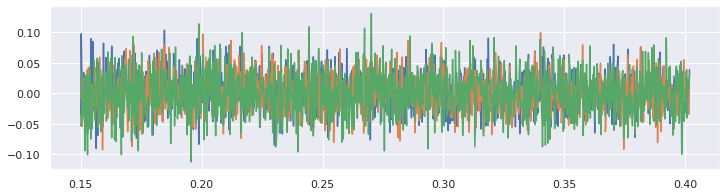

In [8]:
shot = valid_shotset.get_shot(valid_shotset.shot_list[201])

signals = ['poloidal Mirnov probes_01', 'poloidal Mirnov probes_02', 'poloidal Mirnov probes_03',
          # 'poloidal Mirnov probes_05', 'poloidal Mirnov probes_06'
          ]
# signals = sxr_name_list[:20]
plt.figure(figsize=(12,3))
for signal_name in signals:
    tag = get_tag_name(signal_name, machine_name)
    signal = shot.get_signal(tag)
    print(signal.attributes['SampleRate'])
    plt.plot(signal.time,signal.data)    
plt.show()         

## Preprocessing and Feature Engineering

In [9]:
from scipy.signal import spectrogram, periodogram, filtfilt, butter,savgol_filter,find_peaks

def spectral_entropy(x, freq, nfft=None):    
    _, psd = periodogram(x, freq, nfft = nfft)   
    # calculate shannon entropy of normalized psd
    psd_norm = psd / np.sum(psd)
    entropy = np.nansum(psd_norm * np.log2(psd_norm))
    return -(entropy / np.log2(psd_norm.size))

In [10]:
WIN = 300 #60 ms
ROLL_WIN = 70

def gen_features(val,col,sample_rate, obs_win, roll_win):        
    row = {}
    x = (val-np.mean(val))/(np.std(val)+1e-9)
    x = x[-obs_win:]
    x = np.pad(x, (obs_win-len(x),0), 'constant', constant_values=0)
    row[f'{col}_std'] = np.nanstd(x)
    row[f'{col}_entropy'] = spectral_entropy(x, sample_rate) 
    row[f'{col}_roll_std_mean']= np.mean(pd.Series(x).rolling(roll_win).std())
    row[f'{col}_roll_std_std']= np.std(pd.Series(x).rolling(roll_win).std())    
    return row

def gen_dataframe(shotset, machine_name, obs_win=WIN, roll_win=WIN//10, is_train=True):
    
    shot_ids = shotset.shot_list
    
    #these are the signals will be extracted
    signals = ['poloidal Mirnov probes_01', 'poloidal Mirnov probes_02', 'poloidal Mirnov probes_03',
          'poloidal Mirnov probes_05', 'poloidal Mirnov probes_06'] + sxr_name_list[:20]    
        
    rows = {}

    for shot_id in shot_ids:    
        row = {}        
        shot = shotset.get_shot(shot_id)
        
        if is_train:
            signal = shot.get_signal(get_tag_name('plasma current', machine_name))
            row['signal_len'] = len(signal.data)
        
        for signal_name in signals:
            tag = get_tag_name(signal_name, machine_name)
            try:
                signal = shot.get_signal(tag)         
            except:
                tag = tag.replace('ABK','GHK')
                try:
                    signal = shot.get_signal(tag)         
                except:
                    print(f"Fetch signal failed. {shot_id},{signal_name}")
                    continue
            row.update(gen_features(signal.data, signal_name, signal.attributes['SampleRate'], obs_win, roll_win))
        
        if is_train: 
            row['target'] = shot.labels['IsDisrupt'].astype(np.int8)
            if row['target']==1:
                row['downtime'] = shot.labels['DownTime'].astype(np.int32)
        rows[shot_id] = row
        
    return pd.DataFrame.from_dict(rows,'index')   

In [11]:
train_jtext = gen_dataframe(valid_shotset, 'J-TEXT', obs_win=WIN, roll_win=ROLL_WIN)
train_cmod = gen_dataframe(cmod_train_shotset, 'C-Mod', obs_win=WIN, roll_win=ROLL_WIN)

train_jtext['machine'] = 'j-text'
train_cmod['machine'] = 'c-mod'

train = pd.concat([train_jtext,train_cmod])
train.shape

(2130, 104)

## Training

In [12]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,TimeSeriesSplit,GroupKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score,accuracy_score, precision_recall_curve, PrecisionRecallDisplay,f1_score,precision_score,recall_score

def lgbm_cv(train_df, target, features, params=None, n_splits = 5, groups=None, show_plot=False, random_state=42, shuffle=True, multiclass=False,sample_weight=None, kfold = True):        
    models = []
    
    if show_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    if groups is None:
        if kfold:
            folds = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        else:
            folds = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    else:
        folds = GroupKFold(n_splits=n_splits)
        
    oof = np.zeros(len(train_df))  
    fold = np.zeros(len(train_df))   
        
    feature_importance_df = pd.DataFrame()
    fold_aucs = []
    aucs = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target,groups)):
        print('fold:'+ str(fold_))
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target[trn_idx])
        val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target[val_idx])

        if sample_weight is not None:
            trn_data.set_weight(sample_weight[trn_idx])
            val_data.set_weight(sample_weight[val_idx])
        
        clf = lgb.train(params, trn_data, 3000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
        if not multiclass:
            oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
            fold[val_idx] = fold_
            fold_auc = roc_auc_score(target[val_idx], oof[val_idx])
            fold_aucs.append(fold_auc)
            
        
        models.append(clf)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        #auc for binary classification
        if show_plot and not multiclass:
            fpr, tpr, thresholds = roc_curve(target[val_idx], oof[val_idx])
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            ax1.plot(fpr, tpr, lw=1, alpha=0.5, label='ROC fold %d (AUC = %0.2f)' % (fold_, roc_auc)) 
            
            prec, recall, _ = precision_recall_curve(target[val_idx], oof[val_idx])
            PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2, lw=1, alpha=1, label=f'Fold {fold_}')

    if not multiclass:
        print("CV AUC: {:<8.5f}".format(roc_auc_score(target, oof)))
        print("Folds AUC Mean: {:<8.5f}".format(np.mean(fold_aucs)))

    if show_plot:
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax1.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC Curves of CV')
        ax1.legend(loc="lower right")        

        ax2.set_title('Precision Recall Curves of CV')
        ax2.legend(loc="lower right")
        plt.show()
        
    feature_importance_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values('importance',ascending=False)    
    return feature_importance_df, oof, models

training shape:(1463, 100), 0.0936431989063568
fold:0
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[435]	training's auc: 1	valid_1's auc: 0.978738
fold:1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[163]	training's auc: 1	valid_1's auc: 0.99402
fold:2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[155]	training's auc: 1	valid_1's auc: 0.975503
fold:3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	training's auc: 1	valid_1's auc: 0.967871
fold:4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's auc: 1	valid_1's auc: 0.996108
fold:5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's auc: 0.999992	valid_1's auc: 0.975476
CV AUC: 0.94440 
Folds AUC Mean: 0.96

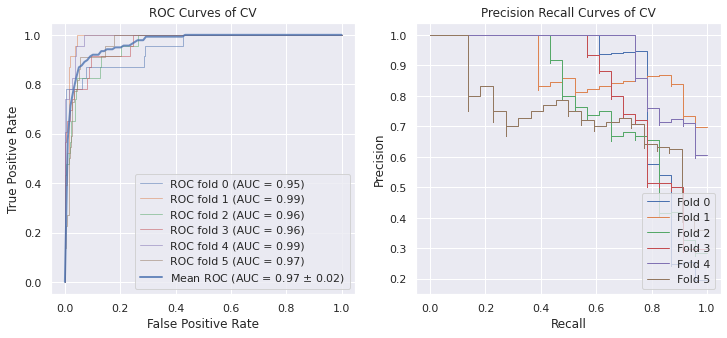

In [13]:
n_splits = 6
dropped = ['target','len','machine', 'weight','signal_len','downtime']
features = [x for x in train.columns if x not in dropped]
train['weight'] = 1

#increase weight
train.loc[train['machine']=='c-mod','weight']=15
train = train[train['signal_len']>=WIN]

params = {'boost': 'gbdt', 'is_unbalance': True, 'feature_fraction': 0.7,   'learning_rate': 0.07,   'max_depth': 5,                       
      'objective': 'binary', 'metric': 'auc', 'verbosity': -1,}

print(f"training shape:{train[features].shape}, {train['target'].mean()}")
fi, oof, models = lgbm_cv(train, train['target'].values, features, n_splits = n_splits, show_plot=True,
                                       params=params,shuffle=True, kfold = False, sample_weight=train['weight'].values)


In [14]:
fi.head(10)

,importance
feature,
poloidal Mirnov probes_06_std,8.0421
poloidal Mirnov probes_03_roll_std_std,7.6232
poloidal Mirnov probes_05_std,7.2095
poloidal Mirnov probes_05_roll_std_std,6.9851
poloidal Mirnov probes_05_entropy,6.7466
poloidal Mirnov probes_03_entropy,6.7362
soft-X-ray_20_roll_std_mean,6.5779
soft-X-ray_20_std,6.4730
poloidal Mirnov probes_01_std,6.3285


## Submission

In [15]:
test_shotset = ShotSet(FileRepo(cmod_test_path))
test = gen_dataframe(test_shotset, machine_name='C-Mod',obs_win=WIN, roll_win=ROLL_WIN, is_train=False)

Fetch signal failed. 1140224020,poloidal Mirnov probes_01
Fetch signal failed. 1140224020,poloidal Mirnov probes_02
Fetch signal failed. 1140224020,poloidal Mirnov probes_03
Fetch signal failed. 1140224020,poloidal Mirnov probes_05
Fetch signal failed. 1140224020,poloidal Mirnov probes_06
Fetch signal failed. 1140224020,soft-X-ray_01
Fetch signal failed. 1140224020,soft-X-ray_02
Fetch signal failed. 1140224020,soft-X-ray_03
Fetch signal failed. 1140224020,soft-X-ray_04
Fetch signal failed. 1140224020,soft-X-ray_05
Fetch signal failed. 1140224020,soft-X-ray_06
Fetch signal failed. 1140224020,soft-X-ray_07
Fetch signal failed. 1140224020,soft-X-ray_08
Fetch signal failed. 1140224020,soft-X-ray_09
Fetch signal failed. 1140224020,soft-X-ray_10
Fetch signal failed. 1140224020,soft-X-ray_11
Fetch signal failed. 1140224020,soft-X-ray_12
Fetch signal failed. 1140224020,soft-X-ray_13
Fetch signal failed. 1140224020,soft-X-ray_14
Fetch signal failed. 1140224020,soft-X-ray_15
Fetch signal failed.

In [16]:
pred = np.zeros(len(test))
for model in models:        
    pred+=model.predict(test[features])/len(models)

test['pred'] = pred

In [20]:
threshold = 0.67

submission = pd.read_csv('SampleSubmission.csv')
submission['shot'] = submission['Shot_list'].str.slice(3).astype(int)

submission = submission.merge(test[['pred']], how='left', left_on='shot', right_index=True)
submission['pred'] = submission['pred'].fillna(1)
submission['Is_disrupt'] = (submission['pred']>np.quantile(submission['pred'],threshold)).astype(np.int8)
submission[['Shot_list','Is_disrupt']].to_csv(f'submission_{threshold}.csv',index=False)

submission.sample(5)

,Shot_list,Is_disrupt,shot,pred
294,ID_1151001020,1,1151001020,0.9589
367,ID_1160718008,0,1160718008,0.1341
262,ID_1150814029,0,1150814029,0.0338
49,ID_1120807007,1,1120807007,0.9926
318,ID_1160429015,0,1160429015,0.0131
